In [1]:
%%capture
# Install HermesPy and its dependencies in the current kernel
# When running on Colabs, a restart of the runtime is required afterwards

import sys
!{sys.executable} -m pip install --quiet hermespy

Implementing Evaluators
=======================

[Evaluators](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.Evaluator) represent the process of estimating performance indicators within Hermes' API, both during simulation runtime and in custom use-cases.
They are, arguably, one of the more complex concepts to grasp for library users not very accustomed to distributed computing.

In order to demonstrate the programming workflow, we'll add an evaluator estimating the average signal power received at a wireless device.
Such an tool could be useful to gain insight into the behaviour of beamformers in multipath environments, or simply as a debugging tool of channel models and waveforms.
Let's get right into it:

In [2]:
from __future__ import annotations
from typing import List

import matplotlib.pyplot as plt
import numpy as np

from hermespy.core import Artifact, Evaluation, EvaluationResult, Evaluator, GridDimension, Hook, Receiver, Reception, Signal
from hermespy.core.visualize import PlotVisualization, StemVisualization, VAT
    

class PowerArtifact(Artifact):
    
    power: float
    
    def __init__(self, power: float) -> None:
        
        self.power = power
        
    def __str__(self) -> str:
        
        return f"{self.power:.2f}"
    
    def to_scalar(self) -> float:
        
        return self.power
    

class PowerEvaluation(Evaluation):
    
    power: np.ndarray
    
    def __init__(self, signal: Signal) -> None:
        
        self.power = signal.power

    def _prepare_visualization(self, figure: plt.Figure | None, axes: VAT, **kwargs) -> StemVisualization:

        ax: plt.Axes = axes.flat[0]
        ax.set_xlabel("Antenna Stream")
        ax.set_ylabel("Power [W]")

        container = ax.stem(np.zeros_like(self.power))
        return StemVisualization(figure, axes, container)

    def _update_visualization(self, visualization: StemVisualization, **kwargs) -> None:
        visualization.container.markerline.set_ydata(self.power)
            
    def artifact(self) -> PowerArtifact:
        
        summed_power = np.sum(self.power, keepdims=False)
        return PowerArtifact(summed_power)


class PowerEvaluationResult(EvaluationResult):
    
    def __init__(
        self,
        grid: List[GridDimension],
        evaluator: PowerEstimator,
        artifacts: np.ndarray,
    ) -> None:

        self.mean_powers = np.empty(artifacts.shape, dtype=float)
        for section_coords in np.ndindex(artifacts.shape):
            self.mean_powers[section_coords] = np.mean([a.power for a in artifacts[section_coords]])

        EvaluationResult.__init__(self, grid, evaluator)

    def _prepare_visualization(self, figure: plt.Figure | None, axes: VAT, **kwargs) -> PlotVisualization:
        
        lines_array = np.empty_like(axes, dtype=object)
        lines_array[0, 0] = self._prepare_multidim_visualization(axes.flat[0])
        return PlotVisualization(figure, axes, lines_array)
        
    def _update_visualization(self, visualization: PlotVisualization, **kwargs) -> None:
        
        self._update_multidim_visualization(self.mean_powers, visualization)

    def to_array(self) -> np.ndarray:
        
        return self.mean_powers


class PowerEstimator(Evaluator):

    __receive_hook: Hook[Reception]
    __reception: Reception | None

    def __init__(self, receiver: Receiver) -> None:
        Evaluator.__init__(self)
        self.__receive_hook = receiver.add_receive_callback(self.__receive_callback)

    def __receive_callback(self, reception: Reception) -> None:
            self.__reception = reception

    def evaluate(self) -> PowerEvaluation:
        
        if self.__reception is None:
            raise RuntimeError("Receiver has not reception available to evaluate")
            
        return PowerEvaluation(self.__reception.signal)
    
    @property
    def abbreviation(self) -> str:
        
        return "Power"
    
    @property
    def title(self) -> str:
        
        return "Received Power"
    
    def generate_result(self, grid: List[GridDimension], artifacts: np.ndarray) -> PowerEvaluationResult:
        
        return PowerEvaluationResult(grid, self, artifacts)

    def __del__(self) -> None:
        self.__receive_hook.remove()

Here's what you're probably thinking right now: [Artifacts](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.Artifact), [Evaluations](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.Evaluation), [EvaluationResults](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.EvaluationResult) and [Evaluators](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.Evaluator), why do we need four interacting classes to investigate a single performance indicator?
The answer is, this structure is required to enable efficient distributed execution of Monte Carlo simulations, while simulatenously offering an easily programmable interface for other use-cases such as software defined radio operation.

The basis is the [Evaluator](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.Evaluator), in our case the  *PowerEstimator*.
Given a single scenario data drop, it generates an [Evaluation](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.Evaluation) object representing the extracted performance indicator information.
This information is then compressed to Artifacts [Artifacts](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.Artifact) for each simulation grid sample and finally collected within the [generate_result](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.Evaluator.generate_result) method of the [Evaluator](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.Evaluator), creating an [EvaluationResult](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.EvaluationResult).

During distributed simulations, the process of generating [Artifacts](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.Artifact) is executed multiple times in parallel, with only the resulting artifacts being sent to the simulation controller, in order to optimize the simulation data throughput between simulation controller and distributed simulation workers.
Hermes is built around the [Ray](https://www.ray.io/), with optimizations like this Monte Carlo simulations become "embarassingly parallel" and, as a consequence, blazingly fast on multicore systems.

We can now define the simulation scenario of a two-device $5 \times 5$ MIMO simplex link transmitting an OFDM waveform over an ideal channel.
Within a Monte Carlo simulation, we sweep the channel gain and observe the effect on the received signal power by our newly created Estimator:

In [3]:
from hermespy.core import ConsoleMode, dB
from hermespy.modem import SimplexLink, ElementType, GridElement, GridResource, SymbolSection, OFDMWaveform, Alamouti
from hermespy.simulation import Simulation


# Create a new Monte Carlo simulation
simulation = Simulation(console_mode=ConsoleMode.SILENT)

# Configure a simplex link between a transmitting and receiving device,
# interconnected by an ideal channel
tx_device = simulation.new_device()
rx_device = simulation.new_device()
link = SimplexLink()
link.connect(tx_device, rx_device)

# Configure an OFDM waveform with a frame consisting of a single symbol section
link.waveform = OFDMWaveform(grid_resources=[GridResource(elements=[GridElement(ElementType.DATA, 1024)])],
                             grid_structure=[SymbolSection(pattern=[0])])

# Configure a sweep over the linking channel's gain
simulation.new_dimension(
    'gain', dB(0, 2, 4, 6, 8, 10),
    simulation.scenario.channel(tx_device, rx_device),
    title="Channel Gain"
)

# Configure our custom power evaluator
power_estimator = PowerEstimator(link)
simulation.add_evaluator(power_estimator)

# Run the simulation
result = simulation.run()

The simulation routine automatically distributes the workload to all detected CPU cores within the system (in this case $24$) and generates *PowerArtifact* objects in parallel.
Once the simulation is finished, a single *PowerEvaluationResult* is generated and stored within a [MonteCarloResult](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.MonteCarloResult) returned by the simulation [run](../api/simulation.simulation.Simulation.rst#hermespy.simulation.simulation.Simulation.run) method.

Calling the result's [plot](../api/core/monte_carlo.rst#hermespy.core.monte_carlo.MonteCarloResult.plot) method will then internally call the evaluation result's [plot](../api/core/visualize.rst#hermespy.core.visualize.Visualizable.plot), resulting in the following performance indicator visualization:

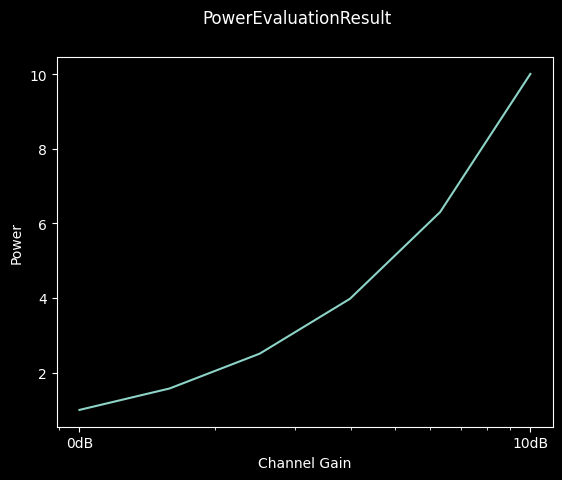

In [4]:
_ = result.plot()

Now while this renders the average power over a number of samples within a simulation, the [Hardware Loop](../api/hardware_loop.rst) has a feature representing performance indicator information in real time during data collection.

This is internally realized by calling the plot funtion of evaluations generated by evaluators, before they are being compressed to artifacts. 
We can demonstrate the output in our current simulation scenario by generating a single drop and calling the evaluator:

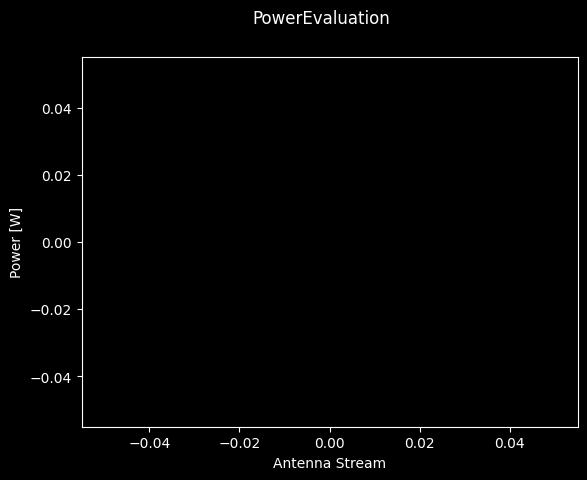

In [5]:
_ = simulation.scenario.drop()

power_estimator.evaluate().visualize()
plt.show()